In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train=pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")
submit_sample=pd.read_csv("./sample_submit.csv", header=None)

df = pd.concat([train, test], sort=False)
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 399
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2000 non-null   int64  
 1   age       2000 non-null   int64  
 2   sex       2000 non-null   object 
 3   bmi       2000 non-null   float64
 4   children  2000 non-null   int64  
 5   smoker    2000 non-null   object 
 6   region    2000 non-null   object 
 7   charges   1600 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 140.6+ KB


,id,age,sex,bmi,children,smoker,region,charges
0,0,26,male,32.665465,3,no,southeast,0.0
1,1,41,male,29.798725,1,no,southwest,0.0
2,2,28,male,32.722029,0,yes,northwest,1.0
3,3,20,female,38.429831,2,no,southeast,0.0
4,4,45,female,29.641854,1,no,northwest,0.0
5,5,20,male,37.785937,2,yes,southeast,1.0
6,6,37,male,43.393374,2,no,northeast,0.0
7,7,41,female,32.280407,1,no,northeast,0.0
8,8,40,male,28.865828,1,no,northeast,0.0
9,9,54,female,33.870887,2,no,northeast,0.0


# Pandas Profiling

In [3]:
# import pandas_profiling

# df.profile_report()

### Divide dataset into two parts (categorical , numerical)

In [4]:
categorical, numerical = [],[]
for z in df.columns:
    t = df.dtypes[z]
    if t=='object':
        categorical.append(z)
    else:
        numerical.append(z)
print("CategoricaL:\n{}".format(categorical))
print("\nNumericaL:\n{}".format(numerical))

CategoricaL:
['sex', 'smoker', 'region']

NumericaL:
['id', 'age', 'bmi', 'children', 'charges']


### Heat map for Correlation coefficient

<AxesSubplot:>

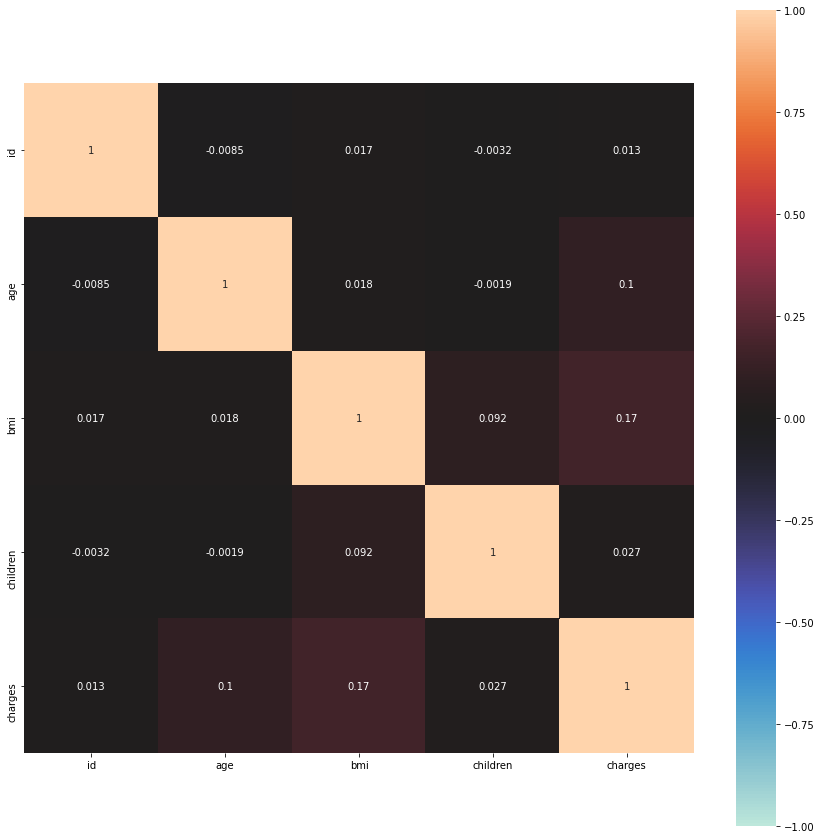

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

df_corr = df.corr()
plt.figure(figsize=(15, 15)) 
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, square=True, annot=True)

### Scatter plot

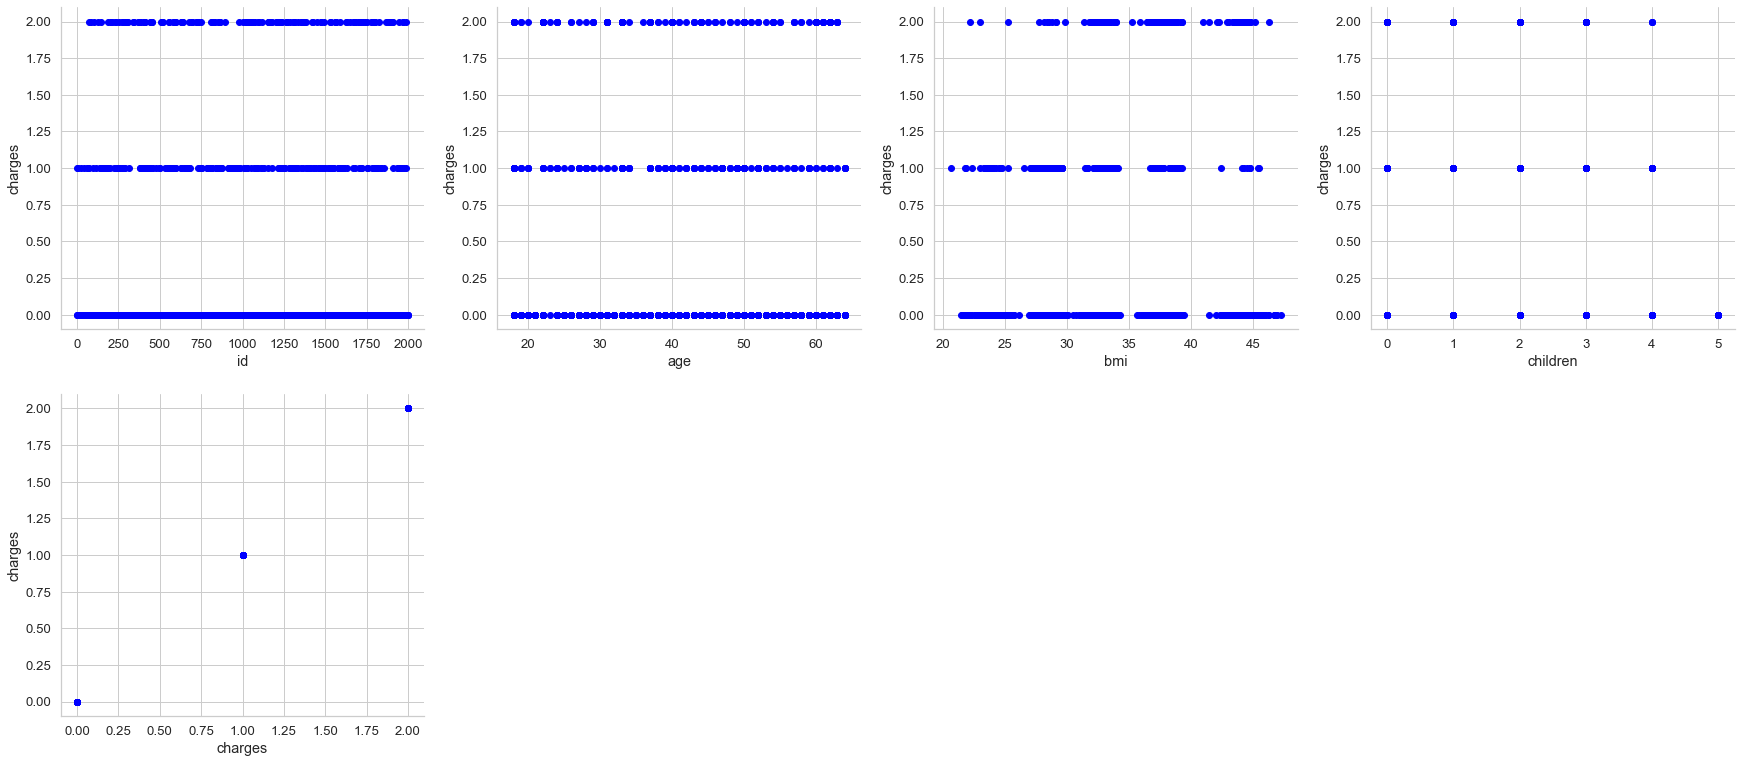

In [6]:
# We shall plot these figures
plt.figure(figsize=(30, 70))
sns.set(font_scale= 1.2)
sns.set_style('whitegrid')

for i, features in enumerate(numerical):
    plt.subplot(10, 4, i+1)
    plt.scatter(data=df.iloc[:len(train)], x=features, y='charges', color ="blue")
    plt.xlabel(features)
    plt.ylabel('charges')
    
sns.despine()

### Creating Dummy values

In [7]:
df =pd.get_dummies(df, columns=categorical, drop_first=True)

### Separate Data

In [8]:
#df = pd.get_dummies(df)
train = df[:len(train)]
test = df[len(train):]
df.head()

,id,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,26,32.665465,3,0.0,1,0,0,1,0
1,1,41,29.798725,1,0.0,1,0,0,0,1
2,2,28,32.722029,0,1.0,1,1,1,0,0
3,3,20,38.429831,2,0.0,0,0,0,1,0
4,4,45,29.641854,1,0.0,0,0,1,0,0


### LightGBM

In [9]:
y_train = train['charges']
X_train = train.drop(['charges'], axis=1)
X_test = test.drop(['charges'], axis=1)


In [10]:
import optuna.integration.lightgbm as lgb # Optuna 
# import lightgbm as lgb 
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score

In [ ]:
y_lgb_preds = []
models = []
y_lgb_oof_train = np.zeros((len(X_train),3))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'task' : 'train',
    'boosting_type' : 'gbdt',
    'objective': 'multiclass',
    'num_class': 3,
    'metric' : 'multi_logloss',
    'max_bin' : 255,
    'num_leaves' : 40,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.9,
    'bagging_fraction' : 0.8,
    'bagging_freq': 5,
    'verbose' : -1
}

# Cross Validation
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train,y_train)):
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]
    
    # Train Dataset
    lgb_train = lgb.Dataset(X_tr, y_tr)

    # Evaluation Dataset (early_stopping_rounds)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    evals_result = {} #結果を格納するための辞書
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['train','eval'],
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    verbose_eval=100,
                    evals_result=evals_result
                   )
    # Out-of-hold of train data
    y_lgb_oof_train[valid_index] = \
        gbm.predict(X_val, num_iteration=gbm.best_iteration)
    
    # Prediction for X_test data
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    
    # Append Prediction data 
    y_lgb_preds.append(y_pred)
    models.append(gbm)


[I 2021-06-12 15:41:30,228] A new study created in memory with name: no-name-a223a624-6c2d-4927-a24d-c4e5075867fd
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.342547	eval's multi_logloss: 0.392804
[200]	train's multi_logloss: 0.237981	eval's multi_logloss: 0.345968
Early stopping, best iteration is:
[265]	train's multi_logloss: 0.191915	eval's multi_logloss: 0.33943


feature_fraction, val_score: 0.339430:  14%|######4                                      | 1/7 [00:00<00:05,  1.15it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.356509	eval's multi_logloss: 0.409916
[200]	train's multi_logloss: 0.248076	eval's multi_logloss: 0.357354
[300]	train's multi_logloss: 0.181052	eval's multi_logloss: 0.34415
Early stopping, best iteration is:
[296]	train's multi_logloss: 0.183275	eval's multi_logloss: 0.343923


feature_fraction, val_score: 0.339430:  29%|############8                                | 2/7 [00:01<00:04,  1.16it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232172	eval's multi_logloss: 0.34051
Early stopping, best iteration is:
[229]	train's multi_logloss: 0.21101	eval's multi_logloss: 0.338055


feature_fraction, val_score: 0.338055:  43%|###################2                         | 3/7 [00:02<00:03,  1.27it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.372485	eval's multi_logloss: 0.426657
[200]	train's multi_logloss: 0.263919	eval's multi_logloss: 0.369664
[300]	train's multi_logloss: 0.197006	eval's multi_logloss: 0.34876
Early stopping, best iteration is:
[349]	train's multi_logloss: 0.171737	eval's multi_logloss: 0.345644


feature_fraction, val_score: 0.338055:  57%|#########################7                   | 4/7 [00:03<00:02,  1.17it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.329947	eval's multi_logloss: 0.373655
[200]	train's multi_logloss: 0.229401	eval's multi_logloss: 0.341164


feature_fraction, val_score: 0.338055:  71%|################################1            | 5/7 [00:04<00:01,  1.23it/s]

Early stopping, best iteration is:
[200]	train's multi_logloss: 0.229401	eval's multi_logloss: 0.341164
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.372485	eval's multi_logloss: 0.426657
[200]	train's multi_logloss: 0.263919	eval's multi_logloss: 0.369664
[300]	train's multi_logloss: 0.197006	eval's multi_logloss: 0.34876
Early stopping, best iteration is:
[349]	train's multi_logloss: 0.171737	eval's multi_logloss: 0.345644


feature_fraction, val_score: 0.338055:  86%|######################################5      | 6/7 [00:05<00:01,  1.06s/it]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.453082	eval's multi_logloss: 0.544789


num_leaves, val_score: 0.338055:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[200]	train's multi_logloss: 0.345446	eval's multi_logloss: 0.505887
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.352925	eval's multi_logloss: 0.505446
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:   5%|##5                                               | 1/20 [00:00<00:15,  1.20it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  10%|#####                                             | 2/20 [00:01<00:15,  1.19it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  15%|#######5                                          | 3/20 [00:02<00:14,  1.15it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  20%|##########                                        | 4/20 [00:03<00:14,  1.10it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  25%|############5                                     | 5/20 [00:04<00:13,  1.15it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  30%|###############                                   | 6/20 [00:05<00:12,  1.11it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334889	eval's multi_logloss: 0.381108
[200]	train's multi_logloss: 0.232339	eval's multi_logloss: 0.341117
Early stopping, best iteration is:
[229]	train's multi_logloss: 0.21157	eval's multi_logloss: 0.338915


num_leaves, val_score: 0.338055:  35%|#################5                                | 7/20 [00:06<00:10,  1.20it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  40%|####################                              | 8/20 [00:06<00:10,  1.18it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  45%|######################5                           | 9/20 [00:07<00:09,  1.22it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  50%|########################5                        | 10/20 [00:08<00:08,  1.23it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.420296	eval's multi_logloss: 0.402923
[200]	train's multi_logloss: 0.373504	eval's multi_logloss: 0.361844
[300]	train's multi_logloss: 0.352915	eval's multi_logloss: 0.349765


num_leaves, val_score: 0.338055:  55%|##########################9                      | 11/20 [00:08<00:06,  1.48it/s]

[400]	train's multi_logloss: 0.339509	eval's multi_logloss: 0.344863
[500]	train's multi_logloss: 0.328788	eval's multi_logloss: 0.341303
Early stopping, best iteration is:
[494]	train's multi_logloss: 0.32933	eval's multi_logloss: 0.341207
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  60%|#############################4                   | 12/20 [00:09<00:05,  1.39it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  65%|###############################8                 | 13/20 [00:10<00:05,  1.35it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  70%|##################################3              | 14/20 [00:11<00:04,  1.34it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  75%|####################################7            | 15/20 [00:12<00:04,  1.23it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.338197	eval's multi_logloss: 0.381132


num_leaves, val_score: 0.338055:  80%|#######################################2         | 16/20 [00:12<00:02,  1.36it/s]

[200]	train's multi_logloss: 0.240005	eval's multi_logloss: 0.341257
Early stopping, best iteration is:
[229]	train's multi_logloss: 0.220787	eval's multi_logloss: 0.339159
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  85%|#########################################6       | 17/20 [00:13<00:02,  1.34it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  90%|############################################1    | 18/20 [00:14<00:01,  1.35it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


num_leaves, val_score: 0.338055:  95%|##############################################5  | 19/20 [00:14<00:00,  1.36it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334787	eval's multi_logloss: 0.380964
[200]	train's multi_logloss: 0.232382	eval's multi_logloss: 0.341094


num_leaves, val_score: 0.338055:  95%|##############################################5  | 19/20 [00:15<00:00,  1.36it/s]

Early stopping, best iteration is:
[230]	train's multi_logloss: 0.210711	eval's multi_logloss: 0.338473


bagging, val_score: 0.338055:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.338809	eval's multi_logloss: 0.382145
[200]	train's multi_logloss: 0.238036	eval's multi_logloss: 0.340932
Early stopping, best iteration is:
[237]	train's multi_logloss: 0.212362	eval's multi_logloss: 0.338312


bagging, val_score: 0.338055:  10%|#####3                                               | 1/10 [00:00<00:06,  1.42it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.366402	eval's multi_logloss: 0.387351


bagging, val_score: 0.338055:  10%|#####3                                               | 1/10 [00:01<00:06,  1.42it/s]

[200]	train's multi_logloss: 0.283076	eval's multi_logloss: 0.352346
Early stopping, best iteration is:
[235]	train's multi_logloss: 0.265011	eval's multi_logloss: 0.347302


bagging, val_score: 0.338055:  20%|##########6                                          | 2/10 [00:01<00:04,  1.67it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.345834	eval's multi_logloss: 0.381592
[200]	train's multi_logloss: 0.250244	eval's multi_logloss: 0.343285


bagging, val_score: 0.338055:  20%|##########6                                          | 2/10 [00:01<00:04,  1.67it/s]

Early stopping, best iteration is:
[258]	train's multi_logloss: 0.211889	eval's multi_logloss: 0.339736


bagging, val_score: 0.338055:  30%|###############9                                     | 3/10 [00:01<00:04,  1.50it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.373887	eval's multi_logloss: 0.393029
[200]	train's multi_logloss: 0.294019	eval's multi_logloss: 0.351286
Early stopping, best iteration is:
[272]	train's multi_logloss: 0.257034	eval's multi_logloss: 0.344506


bagging, val_score: 0.338055:  40%|#####################2                               | 4/10 [00:02<00:03,  1.59it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.340418	eval's multi_logloss: 0.38124
[200]	train's multi_logloss: 0.240638	eval's multi_logloss: 0.338549
Early stopping, best iteration is:
[230]	train's multi_logloss: 0.219106	eval's multi_logloss: 0.336333


bagging, val_score: 0.336333:  50%|##########################5                          | 5/10 [00:03<00:03,  1.53it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.345218	eval's multi_logloss: 0.382568


bagging, val_score: 0.336333:  50%|##########################5                          | 5/10 [00:03<00:03,  1.53it/s]

[200]	train's multi_logloss: 0.248339	eval's multi_logloss: 0.342831
Early stopping, best iteration is:
[225]	train's multi_logloss: 0.230319	eval's multi_logloss: 0.34002


bagging, val_score: 0.336333:  60%|###############################8                     | 6/10 [00:03<00:02,  1.57it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.325799	eval's multi_logloss: 0.38113
[200]	train's multi_logloss: 0.217468	eval's multi_logloss: 0.341177


bagging, val_score: 0.336333:  70%|#####################################                | 7/10 [00:04<00:01,  1.56it/s]

Early stopping, best iteration is:
[220]	train's multi_logloss: 0.202153	eval's multi_logloss: 0.33939
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.359703	eval's multi_logloss: 0.387967
[200]	train's multi_logloss: 0.27172	eval's multi_logloss: 0.348154
Early stopping, best iteration is:
[225]	train's multi_logloss: 0.255841	eval's multi_logloss: 0.343454


bagging, val_score: 0.336333:  80%|##########################################4          | 8/10 [00:05<00:01,  1.66it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321396	eval's multi_logloss: 0.380597
[200]	train's multi_logloss: 0.212848	eval's multi_logloss: 0.337532
Early stopping, best iteration is:
[224]	train's multi_logloss: 0.194118	eval's multi_logloss: 0.335993


bagging, val_score: 0.335993:  90%|###############################################7     | 9/10 [00:05<00:00,  1.58it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.351966	eval's multi_logloss: 0.384655
[200]	train's multi_logloss: 0.26071	eval's multi_logloss: 0.343329
Early stopping, best iteration is:
[240]	train's multi_logloss: 0.234158	eval's multi_logloss: 0.339058


feature_fraction_stage2, val_score: 0.335993:   0%|                                              | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.318783	eval's multi_logloss: 0.371166


feature_fraction_stage2, val_score: 0.335993:  17%|######3                               | 1/6 [00:00<00:03,  1.53it/s]

[200]	train's multi_logloss: 0.20816	eval's multi_logloss: 0.336589
Early stopping, best iteration is:
[191]	train's multi_logloss: 0.216306	eval's multi_logloss: 0.336078
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.318783	eval's multi_logloss: 0.371166


feature_fraction_stage2, val_score: 0.335993:  33%|############6                         | 2/6 [00:01<00:02,  1.56it/s]

[200]	train's multi_logloss: 0.20816	eval's multi_logloss: 0.336589
Early stopping, best iteration is:
[191]	train's multi_logloss: 0.216306	eval's multi_logloss: 0.336078
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321396	eval's multi_logloss: 0.380597
[200]	train's multi_logloss: 0.212848	eval's multi_logloss: 0.337532
Early stopping, best iteration is:
[224]	train's multi_logloss: 0.194118	eval's multi_logloss: 0.335993


feature_fraction_stage2, val_score: 0.335993:  50%|###################                   | 3/6 [00:02<00:02,  1.33it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321396	eval's multi_logloss: 0.380597
[200]	train's multi_logloss: 0.212848	eval's multi_logloss: 0.337532
Early stopping, best iteration is:
[224]	train's multi_logloss: 0.194118	eval's multi_logloss: 0.335993


feature_fraction_stage2, val_score: 0.335993:  67%|#########################3            | 4/6 [00:02<00:01,  1.36it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321396	eval's multi_logloss: 0.380597
[200]	train's multi_logloss: 0.212848	eval's multi_logloss: 0.337532
Early stopping, best iteration is:
[224]	train's multi_logloss: 0.194118	eval's multi_logloss: 0.335993


feature_fraction_stage2, val_score: 0.335993:  83%|###############################6      | 5/6 [00:03<00:00,  1.33it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.327981	eval's multi_logloss: 0.395305
[200]	train's multi_logloss: 0.215975	eval's multi_logloss: 0.349372
Early stopping, best iteration is:
[261]	train's multi_logloss: 0.17112	eval's multi_logloss: 0.344148


regularization_factors, val_score: 0.335993:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.342333	eval's multi_logloss: 0.386819
[200]	train's multi_logloss: 0.241343	eval's multi_logloss: 0.338749
Early stopping, best iteration is:
[236]	train's multi_logloss: 0.215895	eval's multi_logloss: 0.335496


regularization_factors, val_score: 0.335496:   5%|#9                                    | 1/20 [00:00<00:12,  1.49it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.417689	eval's multi_logloss: 0.410962
[200]	train's multi_logloss: 0.363525	eval's multi_logloss: 0.367422
[300]	train's multi_logloss: 0.341452	eval's multi_logloss: 0.353627
[400]	train's multi_logloss: 0.332151	eval's multi_logloss: 0.349184
[500]	train's multi_logloss: 0.326562	eval's multi_logloss: 0.347189
[600]	train's multi_logloss: 0.323209	eval's multi_logloss: 0.346328
[700]	train's multi_logloss: 0.321573	eval's multi_logloss: 0.345609
[800]	train's multi_logloss: 0.320544	eval's multi_logloss: 0.344987


regularization_factors, val_score: 0.335496:   5%|#9                                    | 1/20 [00:01<00:12,  1.49it/s]

[900]	train's multi_logloss: 0.320192	eval's multi_logloss: 0.344745
[1000]	train's multi_logloss: 0.320099	eval's multi_logloss: 0.344663
Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.320099	eval's multi_logloss: 0.344663


regularization_factors, val_score: 0.335496:  10%|###8                                  | 2/20 [00:01<00:15,  1.17it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321397	eval's multi_logloss: 0.380598
[200]	train's multi_logloss: 0.212535	eval's multi_logloss: 0.337859
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.199057	eval's multi_logloss: 0.336568


regularization_factors, val_score: 0.335496:  15%|#####7                                | 3/20 [00:03<00:19,  1.15s/it]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321435	eval's multi_logloss: 0.380531
[200]	train's multi_logloss: 0.212361	eval's multi_logloss: 0.33813
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.199027	eval's multi_logloss: 0.336823


regularization_factors, val_score: 0.335496:  20%|#######6                              | 4/20 [00:04<00:17,  1.07s/it]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.377588	eval's multi_logloss: 0.390107
[200]	train's multi_logloss: 0.297823	eval's multi_logloss: 0.342451
[300]	train's multi_logloss: 0.246126	eval's multi_logloss: 0.334362


regularization_factors, val_score: 0.333887:  25%|#########5                            | 5/20 [00:04<00:14,  1.04it/s]

Early stopping, best iteration is:
[340]	train's multi_logloss: 0.230559	eval's multi_logloss: 0.333887
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321297	eval's multi_logloss: 0.380772


regularization_factors, val_score: 0.333887:  30%|###########4                          | 6/20 [00:05<00:11,  1.19it/s]

[200]	train's multi_logloss: 0.212389	eval's multi_logloss: 0.338169
Early stopping, best iteration is:
[222]	train's multi_logloss: 0.195024	eval's multi_logloss: 0.336759
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.425124	eval's multi_logloss: 0.417159
[200]	train's multi_logloss: 0.375375	eval's multi_logloss: 0.374426
[300]	train's multi_logloss: 0.356865	eval's multi_logloss: 0.360997
[400]	train's multi_logloss: 0.348902	eval's multi_logloss: 0.355192
[500]	train's multi_logloss: 0.345213	eval's multi_logloss: 0.352123
[600]	train's multi_logloss: 0.343502	eval's multi_logloss: 0.350474
[700]	train's multi_logloss: 0.342473	eval's multi_logloss: 0.3496
[800]	train's multi_logloss: 0.342106	eval's multi_logloss: 0.349269
[900]	train's multi_logloss: 0.341961	eval's multi_logloss: 0.349146
[1000]	train's multi_logloss: 0.341846	eval's multi_logloss: 0.34904
Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 

regularization_factors, val_score: 0.333887:  35%|#############3                        | 7/20 [00:06<00:10,  1.25it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321332	eval's multi_logloss: 0.380864


regularization_factors, val_score: 0.333887:  35%|#############3                        | 7/20 [00:06<00:10,  1.25it/s]

[200]	train's multi_logloss: 0.211997	eval's multi_logloss: 0.3381
Early stopping, best iteration is:
[222]	train's multi_logloss: 0.194739	eval's multi_logloss: 0.336239


regularization_factors, val_score: 0.333887:  40%|###############2                      | 8/20 [00:06<00:08,  1.35it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.332646	eval's multi_logloss: 0.383031


regularization_factors, val_score: 0.333887:  45%|#################1                    | 9/20 [00:07<00:07,  1.43it/s][I 2021-06-12 15:42:10,984] Trial 51 finished with value: 0.3347784883793742 and parameters: {'lambda_l1': 0.27528523286337514, 'lambda_l2': 0.0011453015136736711}. Best is trial 47 with value: 0.333886559504741.


[200]	train's multi_logloss: 0.229557	eval's multi_logloss: 0.336074
Early stopping, best iteration is:
[227]	train's multi_logloss: 0.209603	eval's multi_logloss: 0.334778


regularization_factors, val_score: 0.333887:  45%|#################1                    | 9/20 [00:07<00:07,  1.43it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321764	eval's multi_logloss: 0.380391


regularization_factors, val_score: 0.333887:  50%|##################5                  | 10/20 [00:07<00:06,  1.51it/s]

[200]	train's multi_logloss: 0.213173	eval's multi_logloss: 0.336633
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.199476	eval's multi_logloss: 0.334524
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321738	eval's multi_logloss: 0.38137


regularization_factors, val_score: 0.333887:  55%|####################3                | 11/20 [00:08<00:05,  1.55it/s]

[200]	train's multi_logloss: 0.213466	eval's multi_logloss: 0.336647
Early stopping, best iteration is:
[210]	train's multi_logloss: 0.205494	eval's multi_logloss: 0.335815
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.333802	eval's multi_logloss: 0.38514
[200]	train's multi_logloss: 0.229655	eval's multi_logloss: 0.340435


regularization_factors, val_score: 0.333887:  60%|######################2              | 12/20 [00:09<00:05,  1.58it/s]

Early stopping, best iteration is:
[231]	train's multi_logloss: 0.206821	eval's multi_logloss: 0.338552
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324012	eval's multi_logloss: 0.382661


regularization_factors, val_score: 0.333887:  65%|########################             | 13/20 [00:09<00:04,  1.58it/s]

[200]	train's multi_logloss: 0.2165	eval's multi_logloss: 0.337993
Early stopping, best iteration is:
[221]	train's multi_logloss: 0.200347	eval's multi_logloss: 0.33584
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.322551	eval's multi_logloss: 0.381195


regularization_factors, val_score: 0.333887:  65%|########################             | 13/20 [00:10<00:04,  1.58it/s]

[200]	train's multi_logloss: 0.214697	eval's multi_logloss: 0.337198
Early stopping, best iteration is:
[227]	train's multi_logloss: 0.193455	eval's multi_logloss: 0.335065


regularization_factors, val_score: 0.333887:  70%|#########################9           | 14/20 [00:10<00:03,  1.58it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321422	eval's multi_logloss: 0.380858


regularization_factors, val_score: 0.333887:  75%|###########################7         | 15/20 [00:11<00:03,  1.60it/s]

[200]	train's multi_logloss: 0.212481	eval's multi_logloss: 0.338935
Early stopping, best iteration is:
[210]	train's multi_logloss: 0.204647	eval's multi_logloss: 0.338021
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.333312	eval's multi_logloss: 0.383726


regularization_factors, val_score: 0.333887:  80%|#############################6       | 16/20 [00:11<00:02,  1.59it/s]

[200]	train's multi_logloss: 0.230622	eval's multi_logloss: 0.33635
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.217854	eval's multi_logloss: 0.335285
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321397	eval's multi_logloss: 0.380594


regularization_factors, val_score: 0.333887:  80%|#############################6       | 16/20 [00:12<00:02,  1.59it/s]

[200]	train's multi_logloss: 0.212395	eval's multi_logloss: 0.337182
Early stopping, best iteration is:
[219]	train's multi_logloss: 0.197539	eval's multi_logloss: 0.336091


regularization_factors, val_score: 0.333887:  85%|###############################4     | 17/20 [00:12<00:01,  1.50it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.321278	eval's multi_logloss: 0.380779


regularization_factors, val_score: 0.333887:  90%|#################################3   | 18/20 [00:13<00:01,  1.56it/s]

[200]	train's multi_logloss: 0.211883	eval's multi_logloss: 0.338515
Early stopping, best iteration is:
[212]	train's multi_logloss: 0.202266	eval's multi_logloss: 0.337326
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.388086	eval's multi_logloss: 0.399583
[200]	train's multi_logloss: 0.303818	eval's multi_logloss: 0.348316


regularization_factors, val_score: 0.333887:  95%|###################################1 | 19/20 [00:13<00:00,  1.53it/s]

[300]	train's multi_logloss: 0.252345	eval's multi_logloss: 0.336532
Early stopping, best iteration is:
[314]	train's multi_logloss: 0.246254	eval's multi_logloss: 0.336314
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.337152	eval's multi_logloss: 0.383608


regularization_factors, val_score: 0.333887:  95%|###################################1 | 19/20 [00:14<00:00,  1.53it/s]

[200]	train's multi_logloss: 0.235975	eval's multi_logloss: 0.335717
Early stopping, best iteration is:
[236]	train's multi_logloss: 0.210459	eval's multi_logloss: 0.333964


min_data_in_leaf, val_score: 0.333887:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.396331	eval's multi_logloss: 0.391686
[200]	train's multi_logloss: 0.329764	eval's multi_logloss: 0.347372
[300]	train's multi_logloss: 0.294279	eval's multi_logloss: 0.335667


min_data_in_leaf, val_score: 0.332504:  20%|#########                                    | 1/5 [00:00<00:02,  1.83it/s]

[400]	train's multi_logloss: 0.269245	eval's multi_logloss: 0.332561
Early stopping, best iteration is:
[391]	train's multi_logloss: 0.271504	eval's multi_logloss: 0.332504
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.414614	eval's multi_logloss: 0.406854
[200]	train's multi_logloss: 0.359753	eval's multi_logloss: 0.364429
[300]	train's multi_logloss: 0.332456	eval's multi_logloss: 0.34891
[400]	train's multi_logloss: 0.312629	eval's multi_logloss: 0.342906


min_data_in_leaf, val_score: 0.332504:  40%|##################                           | 2/5 [00:01<00:01,  1.98it/s]

Early stopping, best iteration is:
[429]	train's multi_logloss: 0.308241	eval's multi_logloss: 0.342297
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.382333	eval's multi_logloss: 0.390809
[200]	train's multi_logloss: 0.306582	eval's multi_logloss: 0.341079


min_data_in_leaf, val_score: 0.332504:  60%|###########################                  | 3/5 [00:01<00:01,  1.85it/s]

[300]	train's multi_logloss: 0.258035	eval's multi_logloss: 0.332785
Early stopping, best iteration is:
[303]	train's multi_logloss: 0.256885	eval's multi_logloss: 0.332675
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.352759	eval's multi_logloss: 0.39098
[200]	train's multi_logloss: 0.260578	eval's multi_logloss: 0.346687


min_data_in_leaf, val_score: 0.332504:  60%|###########################                  | 3/5 [00:02<00:01,  1.85it/s]

[300]	train's multi_logloss: 0.207416	eval's multi_logloss: 0.339204
Early stopping, best iteration is:
[299]	train's multi_logloss: 0.207838	eval's multi_logloss: 0.339175


min_data_in_leaf, val_score: 0.332504:  80%|####################################         | 4/5 [00:02<00:00,  1.37it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.362996	eval's multi_logloss: 0.391793
[200]	train's multi_logloss: 0.275457	eval's multi_logloss: 0.345737
[300]	train's multi_logloss: 0.224455	eval's multi_logloss: 0.336956
Early stopping, best iteration is:
[360]	train's multi_logloss: 0.201458	eval's multi_logloss: 0.336173


min_data_in_leaf, val_score: 0.332504: 100%|#############################################| 5/5 [00:03<00:00,  1.40it/s]
[I 2021-06-12 15:42:21,504] A new study created in memory with name: no-name-c644f699-fb56-4388-a5c5-dc15d43b7590
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390181
Early stopping, best iteration is:
[172]	train's multi_logloss: 0.249631	eval's multi_logloss: 0.364702


feature_fraction, val_score: 0.364702:  14%|######4                                      | 1/7 [00:00<00:02,  2.01it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.353331	eval's multi_logloss: 0.424781
[200]	train's multi_logloss: 0.245632	eval's multi_logloss: 0.378962


feature_fraction, val_score: 0.364702:  29%|############8                                | 2/7 [00:01<00:03,  1.67it/s]

Early stopping, best iteration is:
[249]	train's multi_logloss: 0.209669	eval's multi_logloss: 0.371962
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.453618	eval's multi_logloss: 0.550819
[200]	train's multi_logloss: 0.344462	eval's multi_logloss: 0.512996


feature_fraction, val_score: 0.364702:  43%|###################2                         | 3/7 [00:01<00:02,  1.66it/s]

Early stopping, best iteration is:
[230]	train's multi_logloss: 0.316598	eval's multi_logloss: 0.502003
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.331478	eval's multi_logloss: 0.401039
[200]	train's multi_logloss: 0.228784	eval's multi_logloss: 0.370463
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.236507	eval's multi_logloss: 0.370144


feature_fraction, val_score: 0.364702:  57%|#########################7                   | 4/7 [00:02<00:01,  1.73it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.370643	eval's multi_logloss: 0.441018
[200]	train's multi_logloss: 0.261949	eval's multi_logloss: 0.390804


feature_fraction, val_score: 0.364702:  57%|#########################7                   | 4/7 [00:03<00:01,  1.73it/s]

[300]	train's multi_logloss: 0.194801	eval's multi_logloss: 0.374519
Early stopping, best iteration is:
[299]	train's multi_logloss: 0.195419	eval's multi_logloss: 0.374484


feature_fraction, val_score: 0.364702:  71%|################################1            | 5/7 [00:03<00:01,  1.53it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.370643	eval's multi_logloss: 0.441018
[200]	train's multi_logloss: 0.261949	eval's multi_logloss: 0.390804


feature_fraction, val_score: 0.364702:  71%|################################1            | 5/7 [00:03<00:01,  1.53it/s]

[300]	train's multi_logloss: 0.194801	eval's multi_logloss: 0.374519
Early stopping, best iteration is:
[299]	train's multi_logloss: 0.195419	eval's multi_logloss: 0.374484


feature_fraction, val_score: 0.364702:  86%|######################################5      | 6/7 [00:03<00:00,  1.43it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.340033	eval's multi_logloss: 0.409211
[200]	train's multi_logloss: 0.234988	eval's multi_logloss: 0.371727


num_leaves, val_score: 0.364702:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[239]	train's multi_logloss: 0.206217	eval's multi_logloss: 0.366995
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364658


num_leaves, val_score: 0.364658:   5%|##5                                               | 1/20 [00:00<00:09,  1.96it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.364657:  10%|#####                                             | 2/20 [00:01<00:09,  1.88it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.364657:  15%|#######5                                          | 3/20 [00:01<00:08,  1.91it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.364657:  20%|##########                                        | 4/20 [00:02<00:08,  1.79it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.364657:  25%|############5                                     | 5/20 [00:02<00:08,  1.77it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182


num_leaves, val_score: 0.364657:  30%|###############                                   | 6/20 [00:03<00:08,  1.60it/s]

Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.364657:  35%|#################5                                | 7/20 [00:04<00:07,  1.65it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.342903	eval's multi_logloss: 0.390581


num_leaves, val_score: 0.362597:  40%|####################                              | 8/20 [00:04<00:06,  1.90it/s]

[200]	train's multi_logloss: 0.260334	eval's multi_logloss: 0.363804
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.266437	eval's multi_logloss: 0.362597
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415265	eval's multi_logloss: 0.405128
[200]	train's multi_logloss: 0.373152	eval's multi_logloss: 0.366603


num_leaves, val_score: 0.339424:  45%|######################5                           | 9/20 [00:04<00:05,  2.13it/s]

[300]	train's multi_logloss: 0.352529	eval's multi_logloss: 0.35268
[400]	train's multi_logloss: 0.338023	eval's multi_logloss: 0.345544
[500]	train's multi_logloss: 0.32714	eval's multi_logloss: 0.340458
Early stopping, best iteration is:
[535]	train's multi_logloss: 0.323813	eval's multi_logloss: 0.339424
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.339424:  50%|########################5                        | 10/20 [00:05<00:05,  1.99it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657

num_leaves, val_score: 0.339424:  55%|##########################9                      | 11/20 [00:05<00:04,  1.90it/s]


Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.339424:  60%|#############################4                   | 12/20 [00:06<00:03,  2.26it/s]

[100]	train's multi_logloss: 0.39711	eval's multi_logloss: 0.395198
[200]	train's multi_logloss: 0.3505	eval's multi_logloss: 0.352425
[300]	train's multi_logloss: 0.327421	eval's multi_logloss: 0.343666
Early stopping, best iteration is:
[300]	train's multi_logloss: 0.327421	eval's multi_logloss: 0.343666
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.339424:  60%|#############################4                   | 12/20 [00:06<00:03,  2.26it/s]

[100]	train's multi_logloss: 0.352772	eval's multi_logloss: 0.391394
[200]	train's multi_logloss: 0.278485	eval's multi_logloss: 0.35838
Early stopping, best iteration is:
[240]	train's multi_logloss: 0.258882	eval's multi_logloss: 0.353762


num_leaves, val_score: 0.339424:  65%|###############################8                 | 13/20 [00:06<00:02,  2.47it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415265	eval's multi_logloss: 0.405128
[200]	train's multi_logloss: 0.373152	eval's multi_logloss: 0.366603
[300]	train's multi_logloss: 0.352529	eval's multi_logloss: 0.35268


num_leaves, val_score: 0.339424:  70%|##################################3              | 14/20 [00:06<00:02,  2.44it/s]

[400]	train's multi_logloss: 0.338023	eval's multi_logloss: 0.345544
[500]	train's multi_logloss: 0.32714	eval's multi_logloss: 0.340458
Early stopping, best iteration is:
[535]	train's multi_logloss: 0.323813	eval's multi_logloss: 0.339424
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.339424:  75%|####################################7            | 15/20 [00:07<00:02,  2.23it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657


num_leaves, val_score: 0.339424:  80%|#######################################2         | 16/20 [00:07<00:01,  2.11it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182


num_leaves, val_score: 0.339424:  85%|#########################################6       | 17/20 [00:08<00:01,  1.92it/s]

Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.327675	eval's multi_logloss: 0.390282
Early stopping, best iteration is:
[173]	train's multi_logloss: 0.251296	eval's multi_logloss: 0.364592


num_leaves, val_score: 0.339424:  90%|############################################1    | 18/20 [00:09<00:01,  1.99it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.326755	eval's multi_logloss: 0.390182


num_leaves, val_score: 0.339424:  95%|##############################################5  | 19/20 [00:09<00:00,  1.88it/s]

Early stopping, best iteration is:
[170]	train's multi_logloss: 0.251537	eval's multi_logloss: 0.364657
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.327136	eval's multi_logloss: 0.390088
Early stopping, best iteration is:
[172]	train's multi_logloss: 0.25089	eval's multi_logloss: 0.364664


bagging, val_score: 0.339424:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415978	eval's multi_logloss: 0.406464
[200]	train's multi_logloss: 0.374026	eval's multi_logloss: 0.367438
[300]	train's multi_logloss: 0.354712	eval's multi_logloss: 0.351879


bagging, val_score: 0.339424:  10%|#####3                                               | 1/10 [00:00<00:02,  3.42it/s]

[400]	train's multi_logloss: 0.340684	eval's multi_logloss: 0.34487
Early stopping, best iteration is:
[468]	train's multi_logloss: 0.332806	eval's multi_logloss: 0.342532
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415924	eval's multi_logloss: 0.406291
[200]	train's multi_logloss: 0.374303	eval's multi_logloss: 0.367396


bagging, val_score: 0.339424:  20%|##########6                                          | 2/10 [00:00<00:02,  3.33it/s]

[300]	train's multi_logloss: 0.355369	eval's multi_logloss: 0.352671
[400]	train's multi_logloss: 0.340788	eval's multi_logloss: 0.345141
Early stopping, best iteration is:
[470]	train's multi_logloss: 0.332959	eval's multi_logloss: 0.341823
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.414655	eval's multi_logloss: 0.404742


bagging, val_score: 0.339424:  30%|###############9                                     | 3/10 [00:00<00:02,  3.45it/s]

[200]	train's multi_logloss: 0.372507	eval's multi_logloss: 0.364964
[300]	train's multi_logloss: 0.35187	eval's multi_logloss: 0.35252
[400]	train's multi_logloss: 0.337756	eval's multi_logloss: 0.346952
Early stopping, best iteration is:
[414]	train's multi_logloss: 0.336099	eval's multi_logloss: 0.346103
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.339424:  40%|#####################2                               | 4/10 [00:01<00:01,  3.70it/s]

[100]	train's multi_logloss: 0.415035	eval's multi_logloss: 0.402862
[200]	train's multi_logloss: 0.373069	eval's multi_logloss: 0.367614
[300]	train's multi_logloss: 0.351363	eval's multi_logloss: 0.353903
Early stopping, best iteration is:
[378]	train's multi_logloss: 0.340168	eval's multi_logloss: 0.347494
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.339424:  50%|##########################5                          | 5/10 [00:01<00:01,  3.94it/s]

[100]	train's multi_logloss: 0.415116	eval's multi_logloss: 0.405665
[200]	train's multi_logloss: 0.373176	eval's multi_logloss: 0.365677
[300]	train's multi_logloss: 0.351954	eval's multi_logloss: 0.353021
Early stopping, best iteration is:
[350]	train's multi_logloss: 0.344155	eval's multi_logloss: 0.348626
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415093	eval's multi_logloss: 0.40472
[200]	train's multi_logloss: 0.372869	eval's multi_logloss: 0.366563
[300]	train's multi_logloss: 0.352607	eval's multi_logloss: 0.352818
[400]	train's multi_logloss: 0.3375	eval's multi_logloss: 0.347474


bagging, val_score: 0.339424:  60%|###############################8                     | 6/10 [00:01<00:01,  3.58it/s]

Early stopping, best iteration is:
[432]	train's multi_logloss: 0.333254	eval's multi_logloss: 0.345954
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415806	eval's multi_logloss: 0.404591
[200]	train's multi_logloss: 0.371616	eval's multi_logloss: 0.367016
[300]	train's multi_logloss: 0.350596	eval's multi_logloss: 0.353743


bagging, val_score: 0.339424:  70%|#####################################                | 7/10 [00:01<00:00,  3.82it/s]

Early stopping, best iteration is:
[380]	train's multi_logloss: 0.338694	eval's multi_logloss: 0.347084
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415024	eval's multi_logloss: 0.4055
[200]	train's multi_logloss: 0.372703	eval's multi_logloss: 0.365577
[300]	train's multi_logloss: 0.352161	eval's multi_logloss: 0.354185


bagging, val_score: 0.339424:  80%|##########################################4          | 8/10 [00:02<00:00,  3.87it/s]

[400]	train's multi_logloss: 0.338155	eval's multi_logloss: 0.347835
Early stopping, best iteration is:
[414]	train's multi_logloss: 0.336579	eval's multi_logloss: 0.34645
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.414893	eval's multi_logloss: 0.403936
[200]	train's multi_logloss: 0.373093	eval's multi_logloss: 0.366407


bagging, val_score: 0.339424:  90%|###############################################7     | 9/10 [00:02<00:00,  3.97it/s]

[300]	train's multi_logloss: 0.351211	eval's multi_logloss: 0.355989
Early stopping, best iteration is:
[324]	train's multi_logloss: 0.347616	eval's multi_logloss: 0.353602
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415192	eval's multi_logloss: 0.404457
[200]	train's multi_logloss: 0.372393	eval's multi_logloss: 0.36683


feature_fraction_stage2, val_score: 0.339424:   0%|                                              | 0/3 [00:00<?, ?it/s]

[300]	train's multi_logloss: 0.351802	eval's multi_logloss: 0.353654
Early stopping, best iteration is:
[376]	train's multi_logloss: 0.340128	eval's multi_logloss: 0.348296
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415265	eval's multi_logloss: 0.405128
[200]	train's multi_logloss: 0.373152	eval's multi_logloss: 0.366603


feature_fraction_stage2, val_score: 0.339424:   0%|                                              | 0/3 [00:00<?, ?it/s]

[300]	train's multi_logloss: 0.352529	eval's multi_logloss: 0.35268
[400]	train's multi_logloss: 0.338023	eval's multi_logloss: 0.345544
[500]	train's multi_logloss: 0.32714	eval's multi_logloss: 0.340458
Early stopping, best iteration is:
[535]	train's multi_logloss: 0.323813	eval's multi_logloss: 0.339424


feature_fraction_stage2, val_score: 0.339424:  33%|############6                         | 1/3 [00:00<00:00,  2.81it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616
[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856


feature_fraction_stage2, val_score: 0.338988:  67%|#########################3            | 2/3 [00:00<00:00,  2.79it/s]

[500]	train's multi_logloss: 0.328036	eval's multi_logloss: 0.341175
[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.415265	eval's multi_logloss: 0.405128
[200]	train's multi_logloss: 0.373152	eval's multi_logloss: 0.366603
[300]	train's multi_logloss: 0.352529	eval's multi_logloss: 0.35268
[400]	train's multi_logloss: 0.338023	eval's multi_logloss: 0.345544
[500]	train's multi_logloss: 0.32714	eval's multi_logloss: 0.340458
Early stopping, best iteration is:
[535]	train's multi_logloss: 0.323813	eval's multi_logloss: 0.339424


regularization_factors, val_score: 0.338988:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616
[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503


regularization_factors, val_score: 0.338988:   5%|#9                                    | 1/20 [00:00<00:07,  2.68it/s]

[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328037	eval's multi_logloss: 0.341175
[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419081	eval's multi_logloss: 0.409875
[200]	train's multi_logloss: 0.374018	eval's multi_logloss: 0.367631
[300]	train's multi_logloss: 0.353293	eval's multi_logloss: 0.353605
[400]	train's multi_logloss: 0.338863	eval's multi_logloss: 0.345817


regularization_factors, val_score: 0.338988:  10%|###8                                  | 2/20 [00:00<00:06,  2.79it/s]

[500]	train's multi_logloss: 0.328119	eval's multi_logloss: 0.341102
Early stopping, best iteration is:
[533]	train's multi_logloss: 0.324784	eval's multi_logloss: 0.340254
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616
[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328036	eval's multi_logloss: 0.341175


regularization_factors, val_score: 0.338988:  15%|#####7                                | 3/20 [00:01<00:06,  2.67it/s]

[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616


regularization_factors, val_score: 0.338988:  15%|#####7                                | 3/20 [00:01<00:06,  2.67it/s]

[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328037	eval's multi_logloss: 0.341175
[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988


regularization_factors, val_score: 0.338988:  20%|#######6                              | 4/20 [00:01<00:06,  2.59it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.41907	eval's multi_logloss: 0.409865
[200]	train's multi_logloss: 0.374008	eval's multi_logloss: 0.367625
[300]	train's multi_logloss: 0.353286	eval's multi_logloss: 0.353585


regularization_factors, val_score: 0.338988:  25%|#########5                            | 5/20 [00:01<00:05,  2.74it/s]

[400]	train's multi_logloss: 0.338861	eval's multi_logloss: 0.345684
[500]	train's multi_logloss: 0.328125	eval's multi_logloss: 0.341036
Early stopping, best iteration is:
[533]	train's multi_logloss: 0.324805	eval's multi_logloss: 0.34019
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616
[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328037	eval's multi_logloss: 0.341175
[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236


regularization_factors, val_score: 0.338988:  30%|###########4                          | 6/20 [00:02<00:05,  2.71it/s]

Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.422931	eval's multi_logloss: 0.413719
[200]	train's multi_logloss: 0.377284	eval's multi_logloss: 0.370018


regularization_factors, val_score: 0.338988:  30%|###########4                          | 6/20 [00:02<00:05,  2.71it/s]

[300]	train's multi_logloss: 0.357043	eval's multi_logloss: 0.355673
[400]	train's multi_logloss: 0.343577	eval's multi_logloss: 0.347535
[500]	train's multi_logloss: 0.333323	eval's multi_logloss: 0.342255
[600]	train's multi_logloss: 0.324579	eval's multi_logloss: 0.339329
Early stopping, best iteration is:
[608]	train's multi_logloss: 0.32401	eval's multi_logloss: 0.339059


regularization_factors, val_score: 0.338988:  35%|#############3                        | 7/20 [00:02<00:04,  2.72it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419205	eval's multi_logloss: 0.409964
[200]	train's multi_logloss: 0.374262	eval's multi_logloss: 0.367719
[300]	train's multi_logloss: 0.353576	eval's multi_logloss: 0.353617


regularization_factors, val_score: 0.338900:  40%|###############2                      | 8/20 [00:02<00:04,  2.71it/s]

[400]	train's multi_logloss: 0.339122	eval's multi_logloss: 0.34585
[500]	train's multi_logloss: 0.328379	eval's multi_logloss: 0.341163
[600]	train's multi_logloss: 0.318598	eval's multi_logloss: 0.339154
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317448	eval's multi_logloss: 0.3389
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616
[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328037	eval's multi_logloss: 0.341175


regularization_factors, val_score: 0.338900:  45%|#################1                    | 9/20 [00:03<00:04,  2.70it/s]

[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419403	eval's multi_logloss: 0.410167
[200]	train's multi_logloss: 0.37459	eval's multi_logloss: 0.368006


regularization_factors, val_score: 0.338900:  50%|##################5                  | 10/20 [00:03<00:03,  2.97it/s]

[300]	train's multi_logloss: 0.354014	eval's multi_logloss: 0.353844
Early stopping, best iteration is:
[388]	train's multi_logloss: 0.341143	eval's multi_logloss: 0.346062
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.429939	eval's multi_logloss: 0.420569
[200]	train's multi_logloss: 0.387117	eval's multi_logloss: 0.37788
[300]	train's multi_logloss: 0.369846	eval's multi_logloss: 0.363894


regularization_factors, val_score: 0.338900:  55%|####################3                | 11/20 [00:04<00:03,  2.45it/s]

[400]	train's multi_logloss: 0.35908	eval's multi_logloss: 0.35639
[500]	train's multi_logloss: 0.351549	eval's multi_logloss: 0.351377
[600]	train's multi_logloss: 0.3457	eval's multi_logloss: 0.348483
Early stopping, best iteration is:
[625]	train's multi_logloss: 0.344558	eval's multi_logloss: 0.347959
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616
[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328036	eval's multi_logloss: 0.341175


regularization_factors, val_score: 0.338900:  60%|######################2              | 12/20 [00:04<00:03,  2.50it/s]

[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419059	eval's multi_logloss: 0.409855
[200]	train's multi_logloss: 0.373995	eval's multi_logloss: 0.367616


regularization_factors, val_score: 0.338900:  60%|######################2              | 12/20 [00:04<00:03,  2.50it/s]

[300]	train's multi_logloss: 0.353264	eval's multi_logloss: 0.353503
[400]	train's multi_logloss: 0.338793	eval's multi_logloss: 0.345856
[500]	train's multi_logloss: 0.328036	eval's multi_logloss: 0.341175
[600]	train's multi_logloss: 0.318256	eval's multi_logloss: 0.339236
Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317098	eval's multi_logloss: 0.338988


regularization_factors, val_score: 0.338900:  65%|########################             | 13/20 [00:04<00:02,  2.53it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.42046	eval's multi_logloss: 0.411164
[200]	train's multi_logloss: 0.375815	eval's multi_logloss: 0.368945
[300]	train's multi_logloss: 0.355481	eval's multi_logloss: 0.354826


regularization_factors, val_score: 0.338701:  70%|#########################9           | 14/20 [00:05<00:02,  2.55it/s]

[400]	train's multi_logloss: 0.341579	eval's multi_logloss: 0.346798
[500]	train's multi_logloss: 0.33117	eval's multi_logloss: 0.341749
[600]	train's multi_logloss: 0.321967	eval's multi_logloss: 0.338995
Early stopping, best iteration is:
[615]	train's multi_logloss: 0.320872	eval's multi_logloss: 0.338701
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.440456	eval's multi_logloss: 0.431333
[200]	train's multi_logloss: 0.399573	eval's multi_logloss: 0.389004
[300]	train's multi_logloss: 0.384699	eval's multi_logloss: 0.374242
[400]	train's multi_logloss: 0.377029	eval's multi_logloss: 0.367956
[500]	train's multi_logloss: 0.372233	eval's multi_logloss: 0.363735
[600]	train's multi_logloss: 0.369333	eval's multi_logloss: 0.361113
[700]	train's multi_logloss: 0.367632	eval's multi_logloss: 0.35991
[800]	train's multi_logloss: 0.365752	eval's multi_logloss: 0.358395
[900]	train's multi_logloss: 0.364291	eval's multi_logloss: 0.35741
Early stop

regularization_factors, val_score: 0.338701:  75%|###########################7         | 15/20 [00:05<00:02,  2.30it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.420113	eval's multi_logloss: 0.4109
[200]	train's multi_logloss: 0.375465	eval's multi_logloss: 0.368617
[300]	train's multi_logloss: 0.355108	eval's multi_logloss: 0.354627


regularization_factors, val_score: 0.338701:  80%|#############################6       | 16/20 [00:06<00:01,  2.42it/s]

[400]	train's multi_logloss: 0.340838	eval's multi_logloss: 0.346535
[500]	train's multi_logloss: 0.330397	eval's multi_logloss: 0.341429
Early stopping, best iteration is:
[570]	train's multi_logloss: 0.323635	eval's multi_logloss: 0.3396
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419121	eval's multi_logloss: 0.409878
[200]	train's multi_logloss: 0.374103	eval's multi_logloss: 0.367775
[300]	train's multi_logloss: 0.353361	eval's multi_logloss: 0.353547
[400]	train's multi_logloss: 0.338913	eval's multi_logloss: 0.345775
[500]	train's multi_logloss: 0.328178	eval's multi_logloss: 0.341087
[600]	train's multi_logloss: 0.31841	eval's multi_logloss: 0.339197


regularization_factors, val_score: 0.338701:  85%|###############################4     | 17/20 [00:06<00:01,  2.47it/s]

Early stopping, best iteration is:
[614]	train's multi_logloss: 0.317262	eval's multi_logloss: 0.338936
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.421885	eval's multi_logloss: 0.412828
[200]	train's multi_logloss: 0.377516	eval's multi_logloss: 0.370486


regularization_factors, val_score: 0.338701:  85%|###############################4     | 17/20 [00:06<00:01,  2.47it/s]

[300]	train's multi_logloss: 0.357731	eval's multi_logloss: 0.356743
[400]	train's multi_logloss: 0.344514	eval's multi_logloss: 0.348087
[500]	train's multi_logloss: 0.334386	eval's multi_logloss: 0.342964
[600]	train's multi_logloss: 0.325948	eval's multi_logloss: 0.339829
Early stopping, best iteration is:
[605]	train's multi_logloss: 0.325554	eval's multi_logloss: 0.339576


regularization_factors, val_score: 0.338701:  90%|#################################3   | 18/20 [00:06<00:00,  2.52it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419139	eval's multi_logloss: 0.409895
[200]	train's multi_logloss: 0.374125	eval's multi_logloss: 0.36779
[300]	train's multi_logloss: 0.353394	eval's multi_logloss: 0.353607


regularization_factors, val_score: 0.338701:  95%|###################################1 | 19/20 [00:07<00:00,  2.64it/s]

[400]	train's multi_logloss: 0.338975	eval's multi_logloss: 0.345689
[500]	train's multi_logloss: 0.328215	eval's multi_logloss: 0.340995
Early stopping, best iteration is:
[533]	train's multi_logloss: 0.32489	eval's multi_logloss: 0.340154
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.419079	eval's multi_logloss: 0.409873
[200]	train's multi_logloss: 0.374019	eval's multi_logloss: 0.367633
[300]	train's multi_logloss: 0.353295	eval's multi_logloss: 0.353607
[400]	train's multi_logloss: 0.338864	eval's multi_logloss: 0.34582


min_data_in_leaf, val_score: 0.338701:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[500]	train's multi_logloss: 0.328117	eval's multi_logloss: 0.341074
Early stopping, best iteration is:
[533]	train's multi_logloss: 0.324792	eval's multi_logloss: 0.340231
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.420333	eval's multi_logloss: 0.411286
[200]	train's multi_logloss: 0.375708	eval's multi_logloss: 0.36884


min_data_in_leaf, val_score: 0.337837:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[300]	train's multi_logloss: 0.35535	eval's multi_logloss: 0.353971
[400]	train's multi_logloss: 0.341441	eval's multi_logloss: 0.345369
[500]	train's multi_logloss: 0.330656	eval's multi_logloss: 0.339787
Early stopping, best iteration is:
[569]	train's multi_logloss: 0.323716	eval's multi_logloss: 0.337837


min_data_in_leaf, val_score: 0.337837:  20%|#########                                    | 1/5 [00:00<00:01,  2.70it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.421129	eval's multi_logloss: 0.411566
[200]	train's multi_logloss: 0.376953	eval's multi_logloss: 0.369366
[300]	train's multi_logloss: 0.357373	eval's multi_logloss: 0.354667


min_data_in_leaf, val_score: 0.337837:  40%|##################                           | 2/5 [00:00<00:01,  2.80it/s]

[400]	train's multi_logloss: 0.343994	eval's multi_logloss: 0.346474
[500]	train's multi_logloss: 0.334062	eval's multi_logloss: 0.341275
Early stopping, best iteration is:
[570]	train's multi_logloss: 0.328483	eval's multi_logloss: 0.339328
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.42058	eval's multi_logloss: 0.411424


min_data_in_leaf, val_score: 0.337837:  60%|###########################                  | 3/5 [00:00<00:00,  3.26it/s]

[200]	train's multi_logloss: 0.376063	eval's multi_logloss: 0.369157
[300]	train's multi_logloss: 0.356193	eval's multi_logloss: 0.354674
Early stopping, best iteration is:
[385]	train's multi_logloss: 0.344025	eval's multi_logloss: 0.34674
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.42033	eval's multi_logloss: 0.411298
[200]	train's multi_logloss: 0.375608	eval's multi_logloss: 0.368494
[300]	train's multi_logloss: 0.355311	eval's multi_logloss: 0.354063
[400]	train's multi_logloss: 0.341429	eval's multi_logloss: 0.345357
[500]	train's multi_logloss: 0.33047	eval's multi_logloss: 0.339731
Early stopping, best iteration is:
[570]	train's multi_logloss: 0.323476	eval's multi_logloss: 0.337639


min_data_in_leaf, val_score: 0.337639:  80%|####################################         | 4/5 [00:01<00:00,  3.05it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.427349	eval's multi_logloss: 0.417674
[200]	train's multi_logloss: 0.382355	eval's multi_logloss: 0.372508
[300]	train's multi_logloss: 0.362528	eval's multi_logloss: 0.356474
[400]	train's multi_logloss: 0.350056	eval's multi_logloss: 0.347833


min_data_in_leaf, val_score: 0.337639: 100%|#############################################| 5/5 [00:01<00:00,  3.07it/s]
[I 2021-06-12 15:42:49,951] A new study created in memory with name: no-name-64c2825e-9249-4e08-82e1-c5ba82c0d7e6
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[489]	train's multi_logloss: 0.34192	eval's multi_logloss: 0.343496
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.36707	eval's multi_logloss: 0.451458
[200]	train's multi_logloss: 0.257706	eval's multi_logloss: 0.408873


feature_fraction, val_score: 0.402452:  14%|######4                                      | 1/7 [00:00<00:04,  1.43it/s]

Early stopping, best iteration is:
[255]	train's multi_logloss: 0.216602	eval's multi_logloss: 0.402452
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.337058	eval's multi_logloss: 0.427805
Early stopping, best iteration is:
[186]	train's multi_logloss: 0.243414	eval's multi_logloss: 0.399475

feature_fraction, val_score: 0.399475:  29%|############8                                | 2/7 [00:01<00:03,  1.66it/s]


Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.254027	eval's multi_logloss: 0.393984


feature_fraction, val_score: 0.393984:  43%|###################2                         | 3/7 [00:01<00:02,  1.86it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.350671	eval's multi_logloss: 0.439889


feature_fraction, val_score: 0.393984:  57%|#########################7                   | 4/7 [00:02<00:01,  1.80it/s]

[200]	train's multi_logloss: 0.242147	eval's multi_logloss: 0.403067
Early stopping, best iteration is:
[217]	train's multi_logloss: 0.229258	eval's multi_logloss: 0.401812
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.454417	eval's multi_logloss: 0.543045
[200]	train's multi_logloss: 0.34632	eval's multi_logloss: 0.50207


feature_fraction, val_score: 0.393984:  57%|#########################7                   | 4/7 [00:03<00:01,  1.80it/s]

[300]	train's multi_logloss: 0.272053	eval's multi_logloss: 0.47636
Early stopping, best iteration is:
[302]	train's multi_logloss: 0.270493	eval's multi_logloss: 0.475813


feature_fraction, val_score: 0.393984:  71%|################################1            | 5/7 [00:03<00:01,  1.58it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.36707	eval's multi_logloss: 0.451458
[200]	train's multi_logloss: 0.257706	eval's multi_logloss: 0.408873


feature_fraction, val_score: 0.393984:  86%|######################################5      | 6/7 [00:03<00:00,  1.54it/s]

Early stopping, best iteration is:
[255]	train's multi_logloss: 0.216602	eval's multi_logloss: 0.402452
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.328473	eval's multi_logloss: 0.416148
Early stopping, best iteration is:
[175]	train's multi_logloss: 0.246022	eval's multi_logloss: 0.395688


num_leaves, val_score: 0.393984:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.393753:   5%|##5                                               | 1/20 [00:00<00:10,  1.87it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744


num_leaves, val_score: 0.393753:  10%|#####                                             | 2/20 [00:01<00:10,  1.65it/s]

Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744


num_leaves, val_score: 0.393753:  15%|#######5                                          | 3/20 [00:02<00:12,  1.40it/s]

Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.393753:  20%|##########                                        | 4/20 [00:02<00:09,  1.60it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.393753:  25%|############5                                     | 5/20 [00:03<00:08,  1.72it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.334693	eval's multi_logloss: 0.414616


num_leaves, val_score: 0.392106:  30%|###############                                   | 6/20 [00:03<00:06,  2.09it/s]

Early stopping, best iteration is:
[165]	train's multi_logloss: 0.27225	eval's multi_logloss: 0.392106
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.373048	eval's multi_logloss: 0.418734
[200]	train's multi_logloss: 0.316263	eval's multi_logloss: 0.392673


num_leaves, val_score: 0.392106:  35%|#################5                                | 7/20 [00:03<00:04,  2.63it/s]

Early stopping, best iteration is:
[200]	train's multi_logloss: 0.316263	eval's multi_logloss: 0.392673
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.392106:  40%|####################                              | 8/20 [00:03<00:04,  2.41it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324993	eval's multi_logloss: 0.414581


num_leaves, val_score: 0.392106:  45%|######################5                           | 9/20 [00:04<00:04,  2.47it/s]

Early stopping, best iteration is:
[163]	train's multi_logloss: 0.255381	eval's multi_logloss: 0.393995
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.392106:  50%|########################5                        | 10/20 [00:04<00:04,  2.32it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744


num_leaves, val_score: 0.392106:  55%|##########################9                      | 11/20 [00:05<00:04,  2.24it/s]

Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.449913	eval's multi_logloss: 0.476509
[200]	train's multi_logloss: 0.402851	eval's multi_logloss: 0.436196


num_leaves, val_score: 0.392106:  60%|#############################4                   | 12/20 [00:05<00:03,  2.50it/s]

[300]	train's multi_logloss: 0.380579	eval's multi_logloss: 0.418598
[400]	train's multi_logloss: 0.366782	eval's multi_logloss: 0.406227
[500]	train's multi_logloss: 0.356861	eval's multi_logloss: 0.399163
Early stopping, best iteration is:
[585]	train's multi_logloss: 0.350087	eval's multi_logloss: 0.394501
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.449913	eval's multi_logloss: 0.476509
[200]	train's multi_logloss: 0.402851	eval's multi_logloss: 0.436196
[300]	train's multi_logloss: 0.380579	eval's multi_logloss: 0.418598
[400]	train's multi_logloss: 0.366782	eval's multi_logloss: 0.406227
[500]	train's multi_logloss: 0.356861	eval's multi_logloss: 0.399163


num_leaves, val_score: 0.392106:  65%|###############################8                 | 13/20 [00:05<00:02,  2.69it/s]

Early stopping, best iteration is:
[585]	train's multi_logloss: 0.350087	eval's multi_logloss: 0.394501
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.392106:  75%|####################################7            | 15/20 [00:06<00:01,  3.02it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.368156	eval's multi_logloss: 0.416813
Early stopping, best iteration is:
[160]	train's multi_logloss: 0.325361	eval's multi_logloss: 0.395032
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.392106:  80%|#######################################2         | 16/20 [00:07<00:01,  2.56it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.392106:  85%|#########################################6       | 17/20 [00:07<00:01,  2.29it/s]

Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.392106:  85%|#########################################6       | 17/20 [00:08<00:01,  2.29it/s]

[100]	train's multi_logloss: 0.325912	eval's multi_logloss: 0.414921
Early stopping, best iteration is:
[165]	train's multi_logloss: 0.255662	eval's multi_logloss: 0.39523


num_leaves, val_score: 0.392106:  90%|############################################1    | 18/20 [00:08<00:00,  2.02it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


num_leaves, val_score: 0.392106:  95%|##############################################5  | 19/20 [00:08<00:00,  1.93it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.324496	eval's multi_logloss: 0.414744
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.253095	eval's multi_logloss: 0.393753


bagging, val_score: 0.392106:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.353172	eval's multi_logloss: 0.413257


bagging, val_score: 0.389819:  10%|#####3                                               | 1/10 [00:00<00:03,  2.85it/s]

[200]	train's multi_logloss: 0.27565	eval's multi_logloss: 0.390994
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.281588	eval's multi_logloss: 0.389819
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.389819:  20%|##########6                                          | 2/10 [00:00<00:03,  2.63it/s]

[100]	train's multi_logloss: 0.336986	eval's multi_logloss: 0.409701
Early stopping, best iteration is:
[164]	train's multi_logloss: 0.277376	eval's multi_logloss: 0.39157
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.389819:  30%|###############9                                     | 3/10 [00:01<00:02,  2.99it/s]

[100]	train's multi_logloss: 0.342607	eval's multi_logloss: 0.41507
Early stopping, best iteration is:
[150]	train's multi_logloss: 0.293839	eval's multi_logloss: 0.397216
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.389819:  40%|#####################2                               | 4/10 [00:01<00:01,  3.08it/s]

[100]	train's multi_logloss: 0.330771	eval's multi_logloss: 0.417545
Early stopping, best iteration is:
[178]	train's multi_logloss: 0.26026	eval's multi_logloss: 0.400996
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.389819:  40%|#####################2                               | 4/10 [00:01<00:01,  3.08it/s]

[100]	train's multi_logloss: 0.334397	eval's multi_logloss: 0.41407
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.256319	eval's multi_logloss: 0.391482


bagging, val_score: 0.389819:  50%|##########################5                          | 5/10 [00:01<00:01,  2.95it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.339915	eval's multi_logloss: 0.41422


bagging, val_score: 0.389819:  60%|###############################8                     | 6/10 [00:02<00:01,  3.01it/s]

Early stopping, best iteration is:
[175]	train's multi_logloss: 0.272552	eval's multi_logloss: 0.392373
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.389819:  60%|###############################8                     | 6/10 [00:02<00:01,  3.01it/s]

[100]	train's multi_logloss: 0.338466	eval's multi_logloss: 0.412954
Early stopping, best iteration is:
[185]	train's multi_logloss: 0.2637	eval's multi_logloss: 0.391733


bagging, val_score: 0.389819:  70%|#####################################                | 7/10 [00:02<00:01,  2.88it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.331145	eval's multi_logloss: 0.412739


bagging, val_score: 0.389819:  80%|##########################################4          | 8/10 [00:02<00:00,  2.84it/s]

Early stopping, best iteration is:
[186]	train's multi_logloss: 0.255961	eval's multi_logloss: 0.399277
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.342066	eval's multi_logloss: 0.414565


bagging, val_score: 0.389235:  90%|###############################################7     | 9/10 [00:03<00:00,  2.85it/s]

[200]	train's multi_logloss: 0.260607	eval's multi_logloss: 0.390166
Early stopping, best iteration is:
[206]	train's multi_logloss: 0.256853	eval's multi_logloss: 0.389235
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.389235: 100%|####################################################| 10/10 [00:03<00:00,  2.87it/s]

[100]	train's multi_logloss: 0.331125	eval's multi_logloss: 0.419798
Early stopping, best iteration is:
[158]	train's multi_logloss: 0.277056	eval's multi_logloss: 0.406548



feature_fraction_stage2, val_score: 0.389235:   0%|                                              | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.349379	eval's multi_logloss: 0.418821


feature_fraction_stage2, val_score: 0.386376:  33%|############6                         | 1/3 [00:00<00:00,  2.38it/s]

[200]	train's multi_logloss: 0.26408	eval's multi_logloss: 0.386967
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262255	eval's multi_logloss: 0.386376
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.386376:  33%|############6                         | 1/3 [00:00<00:00,  2.38it/s]

[100]	train's multi_logloss: 0.342066	eval's multi_logloss: 0.414565
[200]	train's multi_logloss: 0.260607	eval's multi_logloss: 0.390166
Early stopping, best iteration is:
[206]	train's multi_logloss: 0.256853	eval's multi_logloss: 0.389235


feature_fraction_stage2, val_score: 0.386376:  67%|#########################3            | 2/3 [00:00<00:00,  2.64it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.342066	eval's multi_logloss: 0.414565


regularization_factors, val_score: 0.386376:   0%|                                              | 0/20 [00:00<?, ?it/s]

[200]	train's multi_logloss: 0.260607	eval's multi_logloss: 0.390166
Early stopping, best iteration is:
[206]	train's multi_logloss: 0.256853	eval's multi_logloss: 0.389235
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.386287:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	train's multi_logloss: 0.349979	eval's multi_logloss: 0.418983
[200]	train's multi_logloss: 0.264841	eval's multi_logloss: 0.387007
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.263039	eval's multi_logloss: 0.386287


regularization_factors, val_score: 0.386287:   5%|#9                                    | 1/20 [00:00<00:07,  2.66it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.350962	eval's multi_logloss: 0.419118


regularization_factors, val_score: 0.386287:  10%|###8                                  | 2/20 [00:00<00:07,  2.54it/s]

[200]	train's multi_logloss: 0.266213	eval's multi_logloss: 0.387009
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.264427	eval's multi_logloss: 0.386523
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.378777	eval's multi_logloss: 0.426934


regularization_factors, val_score: 0.386032:  15%|#####7                                | 3/20 [00:01<00:06,  2.53it/s]

[200]	train's multi_logloss: 0.307858	eval's multi_logloss: 0.391604
Early stopping, best iteration is:
[266]	train's multi_logloss: 0.280004	eval's multi_logloss: 0.386032
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.386032:  15%|#####7                                | 3/20 [00:01<00:06,  2.53it/s]

[100]	train's multi_logloss: 0.349806	eval's multi_logloss: 0.418721
[200]	train's multi_logloss: 0.264626	eval's multi_logloss: 0.387247
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262842	eval's multi_logloss: 0.386639


regularization_factors, val_score: 0.386032:  20%|#######6                              | 4/20 [00:01<00:06,  2.59it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.350619	eval's multi_logloss: 0.418681


regularization_factors, val_score: 0.386032:  25%|#########5                            | 5/20 [00:01<00:05,  2.58it/s]

[200]	train's multi_logloss: 0.265531	eval's multi_logloss: 0.386916
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.263746	eval's multi_logloss: 0.38621
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.386032:  30%|###########4                          | 6/20 [00:02<00:05,  2.43it/s]

[100]	train's multi_logloss: 0.358335	eval's multi_logloss: 0.42067
Early stopping, best iteration is:
[185]	train's multi_logloss: 0.286521	eval's multi_logloss: 0.391094
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.351614	eval's multi_logloss: 0.418827
[200]	train's multi_logloss: 0.267516	eval's multi_logloss: 0.388224
Early stopping, best iteration is:
[206]	train's multi_logloss: 0.264142	eval's multi_logloss: 0.387419


regularization_factors, val_score: 0.386032:  35%|#############3                        | 7/20 [00:02<00:05,  2.26it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.387468	eval's multi_logloss: 0.433189


regularization_factors, val_score: 0.386032:  40%|###############2                      | 8/20 [00:03<00:05,  2.22it/s]

[200]	train's multi_logloss: 0.313089	eval's multi_logloss: 0.395092
Early stopping, best iteration is:
[255]	train's multi_logloss: 0.288971	eval's multi_logloss: 0.388269
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.349379	eval's multi_logloss: 0.418821
[200]	train's multi_logloss: 0.264082	eval's multi_logloss: 0.386909
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.26226	eval's multi_logloss: 0.386304


regularization_factors, val_score: 0.386032:  45%|#################1                    | 9/20 [00:03<00:04,  2.25it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.353031	eval's multi_logloss: 0.419619


regularization_factors, val_score: 0.386032:  50%|##################5                  | 10/20 [00:04<00:04,  2.31it/s]

[200]	train's multi_logloss: 0.269931	eval's multi_logloss: 0.388637
Early stopping, best iteration is:
[207]	train's multi_logloss: 0.266053	eval's multi_logloss: 0.388039
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.349573	eval's multi_logloss: 0.418637
[200]	train's multi_logloss: 0.264307	eval's multi_logloss: 0.386762


regularization_factors, val_score: 0.386032:  55%|####################3                | 11/20 [00:04<00:04,  2.02it/s]

Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262525	eval's multi_logloss: 0.386222
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.34979	eval's multi_logloss: 0.418489


regularization_factors, val_score: 0.386032:  60%|######################2              | 12/20 [00:05<00:03,  2.00it/s]

[200]	train's multi_logloss: 0.264524	eval's multi_logloss: 0.386998
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262734	eval's multi_logloss: 0.386401
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.432979	eval's multi_logloss: 0.456169
[200]	train's multi_logloss: 0.378955	eval's multi_logloss: 0.414576
[300]	train's multi_logloss: 0.356077	eval's multi_logloss: 0.401255
[400]	train's multi_logloss: 0.342559	eval's multi_logloss: 0.395855


regularization_factors, val_score: 0.386032:  65%|########################             | 13/20 [00:05<00:03,  1.90it/s]

[500]	train's multi_logloss: 0.333592	eval's multi_logloss: 0.392786
Early stopping, best iteration is:
[505]	train's multi_logloss: 0.333256	eval's multi_logloss: 0.39257
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.354524	eval's multi_logloss: 0.420044
[200]	train's multi_logloss: 0.270804	eval's multi_logloss: 0.387545

regularization_factors, val_score: 0.386032:  70%|#########################9           | 14/20 [00:06<00:03,  1.93it/s]


Early stopping, best iteration is:
[205]	train's multi_logloss: 0.267912	eval's multi_logloss: 0.386959
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.386032:  70%|#########################9           | 14/20 [00:06<00:03,  1.93it/s]

[100]	train's multi_logloss: 0.3494	eval's multi_logloss: 0.418747
[200]	train's multi_logloss: 0.264207	eval's multi_logloss: 0.387457
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262374	eval's multi_logloss: 0.386849


regularization_factors, val_score: 0.386032:  75%|###########################7         | 15/20 [00:06<00:02,  2.08it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.3495	eval's multi_logloss: 0.418506


regularization_factors, val_score: 0.386032:  80%|#############################6       | 16/20 [00:07<00:01,  2.07it/s]

[200]	train's multi_logloss: 0.264257	eval's multi_logloss: 0.387001
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262461	eval's multi_logloss: 0.386403
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.349379	eval's multi_logloss: 0.418821
[200]	train's multi_logloss: 0.26408	eval's multi_logloss: 0.386967
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262255	eval's multi_logloss: 0.386376


regularization_factors, val_score: 0.386032:  85%|###############################4     | 17/20 [00:07<00:01,  2.03it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.431664	eval's multi_logloss: 0.454941
[200]	train's multi_logloss: 0.384821	eval's multi_logloss: 0.418149


regularization_factors, val_score: 0.386032:  90%|#################################3   | 18/20 [00:08<00:00,  2.08it/s]

[300]	train's multi_logloss: 0.368348	eval's multi_logloss: 0.40633
[400]	train's multi_logloss: 0.359111	eval's multi_logloss: 0.401269
Early stopping, best iteration is:
[461]	train's multi_logloss: 0.355376	eval's multi_logloss: 0.39914
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.386032:  90%|#################################3   | 18/20 [00:08<00:00,  2.08it/s]

[100]	train's multi_logloss: 0.349435	eval's multi_logloss: 0.418833
[200]	train's multi_logloss: 0.26444	eval's multi_logloss: 0.387207
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262627	eval's multi_logloss: 0.386575


regularization_factors, val_score: 0.386032:  95%|###################################1 | 19/20 [00:08<00:00,  2.22it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.349459	eval's multi_logloss: 0.418746


min_data_in_leaf, val_score: 0.386032:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[200]	train's multi_logloss: 0.264363	eval's multi_logloss: 0.386732
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.262571	eval's multi_logloss: 0.386122
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.386032:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	train's multi_logloss: 0.358965	eval's multi_logloss: 0.432746
[200]	train's multi_logloss: 0.28034	eval's multi_logloss: 0.401772
Early stopping, best iteration is:
[220]	train's multi_logloss: 0.270291	eval's multi_logloss: 0.399449


min_data_in_leaf, val_score: 0.386032:  20%|#########                                    | 1/5 [00:00<00:01,  2.14it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.400408	eval's multi_logloss: 0.431885
[200]	train's multi_logloss: 0.34265	eval's multi_logloss: 0.396641


min_data_in_leaf, val_score: 0.386032:  40%|##################                           | 2/5 [00:00<00:01,  2.54it/s]

Early stopping, best iteration is:
[255]	train's multi_logloss: 0.323544	eval's multi_logloss: 0.390478
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.382807	eval's multi_logloss: 0.427188
[200]	train's multi_logloss: 0.315482	eval's multi_logloss: 0.392305


min_data_in_leaf, val_score: 0.382276:  60%|###########################                  | 3/5 [00:01<00:01,  1.88it/s]

[300]	train's multi_logloss: 0.278478	eval's multi_logloss: 0.382354
Early stopping, best iteration is:
[301]	train's multi_logloss: 0.278201	eval's multi_logloss: 0.382276
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.36513	eval's multi_logloss: 0.42956
[200]	train's multi_logloss: 0.289477	eval's multi_logloss: 0.397799


min_data_in_leaf, val_score: 0.382276:  80%|####################################         | 4/5 [00:02<00:00,  1.36it/s]

Early stopping, best iteration is:
[270]	train's multi_logloss: 0.259521	eval's multi_logloss: 0.392484
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.438623	eval's multi_logloss: 0.467201
[200]	train's multi_logloss: 0.377138	eval's multi_logloss: 0.416378
[300]	train's multi_logloss: 0.347468	eval's multi_logloss: 0.398264
[400]	train's multi_logloss: 0.329523	eval's multi_logloss: 0.389961


min_data_in_leaf, val_score: 0.382276: 100%|#############################################| 5/5 [00:03<00:00,  1.64it/s]
[I 2021-06-12 15:43:20,494] A new study created in memory with name: no-name-8e942899-1f3a-4623-ae30-b03950f5288c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Early stopping, best iteration is:
[457]	train's multi_logloss: 0.321844	eval's multi_logloss: 0.386611
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.322149	eval's multi_logloss: 0.42403
Early stopping, best iteration is:
[150]	train's multi_logloss: 0.26537	eval's multi_logloss: 0.403935


feature_fraction, val_score: 0.403935:  14%|######4                                      | 1/7 [00:00<00:02,  2.12it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.366622	eval's multi_logloss: 0.460173
[200]	train's multi_logloss: 0.259382	eval's multi_logloss: 0.413143
[300]	train's multi_logloss: 0.19254	eval's multi_logloss: 0.402365


feature_fraction, val_score: 0.402284:  14%|######4                                      | 1/7 [00:01<00:02,  2.12it/s]

Early stopping, best iteration is:
[302]	train's multi_logloss: 0.191599	eval's multi_logloss: 0.402284


feature_fraction, val_score: 0.402284:  29%|############8                                | 2/7 [00:01<00:04,  1.04it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.349546	eval's multi_logloss: 0.447862
[200]	train's multi_logloss: 0.24284	eval's multi_logloss: 0.406766
Early stopping, best iteration is:
[245]	train's multi_logloss: 0.210157	eval's multi_logloss: 0.399273


feature_fraction, val_score: 0.399273:  43%|###################2                         | 3/7 [00:02<00:03,  1.20it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.327236	eval's multi_logloss: 0.427436
[200]	train's multi_logloss: 0.225916	eval's multi_logloss: 0.401524
Early stopping, best iteration is:
[219]	train's multi_logloss: 0.212278	eval's multi_logloss: 0.39969


feature_fraction, val_score: 0.399273:  57%|#########################7                   | 4/7 [00:03<00:02,  1.32it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335733	eval's multi_logloss: 0.434528
[200]	train's multi_logloss: 0.231532	eval's multi_logloss: 0.400724


feature_fraction, val_score: 0.395347:  71%|################################1            | 5/7 [00:03<00:01,  1.25it/s]

Early stopping, best iteration is:
[244]	train's multi_logloss: 0.200407	eval's multi_logloss: 0.395347
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.366622	eval's multi_logloss: 0.460173
[200]	train's multi_logloss: 0.259382	eval's multi_logloss: 0.413143


feature_fraction, val_score: 0.395347:  71%|################################1            | 5/7 [00:05<00:01,  1.25it/s]

[300]	train's multi_logloss: 0.19254	eval's multi_logloss: 0.402365
Early stopping, best iteration is:
[302]	train's multi_logloss: 0.191599	eval's multi_logloss: 0.402284


feature_fraction, val_score: 0.395347:  86%|######################################5      | 6/7 [00:05<00:00,  1.12it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.452942	eval's multi_logloss: 0.559486
[200]	train's multi_logloss: 0.345878	eval's multi_logloss: 0.522459


num_leaves, val_score: 0.395347:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[273]	train's multi_logloss: 0.289907	eval's multi_logloss: 0.505782
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.394868:   5%|##5                                               | 1/20 [00:00<00:13,  1.37it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.394868:  10%|#####                                             | 2/20 [00:01<00:13,  1.36it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.394868:  15%|#######5                                          | 3/20 [00:02<00:12,  1.32it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.366026	eval's multi_logloss: 0.439001


num_leaves, val_score: 0.393748:  20%|##########                                        | 4/20 [00:02<00:09,  1.69it/s]

[200]	train's multi_logloss: 0.289031	eval's multi_logloss: 0.400388
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.265433	eval's multi_logloss: 0.393748
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  25%|############5                                     | 5/20 [00:03<00:10,  1.48it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  30%|###############                                   | 6/20 [00:04<00:09,  1.47it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  35%|#################5                                | 7/20 [00:05<00:09,  1.31it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  40%|####################                              | 8/20 [00:05<00:09,  1.33it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  45%|######################5                           | 9/20 [00:06<00:08,  1.36it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  50%|########################5                        | 10/20 [00:07<00:07,  1.36it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.376306	eval's multi_logloss: 0.442169
[200]	train's multi_logloss: 0.30733	eval's multi_logloss: 0.404807


num_leaves, val_score: 0.393748:  55%|##########################9                      | 11/20 [00:07<00:05,  1.65it/s]

Early stopping, best iteration is:
[255]	train's multi_logloss: 0.285051	eval's multi_logloss: 0.396305
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.366026	eval's multi_logloss: 0.439001


num_leaves, val_score: 0.393748:  60%|#############################4                   | 12/20 [00:07<00:04,  1.93it/s]

[200]	train's multi_logloss: 0.289031	eval's multi_logloss: 0.400388
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.265433	eval's multi_logloss: 0.393748
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.393748:  65%|###############################8                 | 13/20 [00:08<00:03,  2.22it/s]

[100]	train's multi_logloss: 0.369146	eval's multi_logloss: 0.439902
[200]	train's multi_logloss: 0.294418	eval's multi_logloss: 0.402216
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.271969	eval's multi_logloss: 0.394926
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  70%|##################################3              | 14/20 [00:08<00:03,  1.92it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  75%|####################################7            | 15/20 [00:09<00:02,  1.76it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  80%|#######################################2         | 16/20 [00:10<00:02,  1.65it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  85%|#########################################6       | 17/20 [00:10<00:01,  1.54it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.33717	eval's multi_logloss: 0.433916


num_leaves, val_score: 0.393748:  85%|#########################################6       | 17/20 [00:11<00:01,  1.54it/s]

[200]	train's multi_logloss: 0.235168	eval's multi_logloss: 0.400427
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.203403	eval's multi_logloss: 0.39481


num_leaves, val_score: 0.393748:  90%|############################################1    | 18/20 [00:11<00:01,  1.60it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.335709	eval's multi_logloss: 0.434588
[200]	train's multi_logloss: 0.231574	eval's multi_logloss: 0.400109
Early stopping, best iteration is:
[247]	train's multi_logloss: 0.198316	eval's multi_logloss: 0.394868


num_leaves, val_score: 0.393748:  95%|##############################################5  | 19/20 [00:12<00:00,  1.44it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.397477	eval's multi_logloss: 0.453114
[200]	train's multi_logloss: 0.34215	eval's multi_logloss: 0.416765
[300]	train's multi_logloss: 0.318033	eval's multi_logloss: 0.402566
Early stopping, best iteration is:
[330]	train's multi_logloss: 0.312659	eval's multi_logloss: 0.40039


bagging, val_score: 0.393748:   0%|                                                             | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.374975	eval's multi_logloss: 0.442391


bagging, val_score: 0.393748:  10%|#####3                                               | 1/10 [00:00<00:02,  3.22it/s]

[200]	train's multi_logloss: 0.300402	eval's multi_logloss: 0.404424
Early stopping, best iteration is:
[264]	train's multi_logloss: 0.271175	eval's multi_logloss: 0.396315
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.36505	eval's multi_logloss: 0.439853
[200]	train's multi_logloss: 0.287225	eval's multi_logloss: 0.401591


bagging, val_score: 0.393748:  20%|##########6                                          | 2/10 [00:00<00:02,  2.81it/s]

[300]	train's multi_logloss: 0.244833	eval's multi_logloss: 0.394452
Early stopping, best iteration is:
[295]	train's multi_logloss: 0.246577	eval's multi_logloss: 0.394134
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.368375	eval's multi_logloss: 0.441862


bagging, val_score: 0.393748:  30%|###############9                                     | 3/10 [00:01<00:02,  2.96it/s]

[200]	train's multi_logloss: 0.291494	eval's multi_logloss: 0.40367
Early stopping, best iteration is:
[257]	train's multi_logloss: 0.264852	eval's multi_logloss: 0.397335
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.393748:  30%|###############9                                     | 3/10 [00:01<00:02,  2.96it/s]

[100]	train's multi_logloss: 0.373055	eval's multi_logloss: 0.440871
[200]	train's multi_logloss: 0.297048	eval's multi_logloss: 0.404024
Early stopping, best iteration is:
[264]	train's multi_logloss: 0.269243	eval's multi_logloss: 0.398617


bagging, val_score: 0.393748:  40%|#####################2                               | 4/10 [00:01<00:02,  2.97it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.372306	eval's multi_logloss: 0.441566
[200]	train's multi_logloss: 0.295141	eval's multi_logloss: 0.404954

bagging, val_score: 0.393748:  50%|##########################5                          | 5/10 [00:01<00:01,  3.10it/s]


Early stopping, best iteration is:
[235]	train's multi_logloss: 0.278699	eval's multi_logloss: 0.402625
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.391799:  50%|##########################5                          | 5/10 [00:01<00:01,  3.10it/s]

[100]	train's multi_logloss: 0.367515	eval's multi_logloss: 0.439957
[200]	train's multi_logloss: 0.290008	eval's multi_logloss: 0.400021
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.267082	eval's multi_logloss: 0.391799


bagging, val_score: 0.391799:  60%|###############################8                     | 6/10 [00:01<00:01,  3.13it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.364701	eval's multi_logloss: 0.443529


bagging, val_score: 0.391799:  70%|#####################################                | 7/10 [00:02<00:01,  3.00it/s]

[200]	train's multi_logloss: 0.287621	eval's multi_logloss: 0.406029
Early stopping, best iteration is:
[253]	train's multi_logloss: 0.262767	eval's multi_logloss: 0.399364
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.391799:  70%|#####################################                | 7/10 [00:02<00:01,  3.00it/s]

[100]	train's multi_logloss: 0.364944	eval's multi_logloss: 0.440048
[200]	train's multi_logloss: 0.287892	eval's multi_logloss: 0.401313
Early stopping, best iteration is:
[248]	train's multi_logloss: 0.265206	eval's multi_logloss: 0.394864


bagging, val_score: 0.391799:  80%|##########################################4          | 8/10 [00:02<00:00,  3.07it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.375595	eval's multi_logloss: 0.442782
[200]	train's multi_logloss: 0.302075	eval's multi_logloss: 0.403077


bagging, val_score: 0.391799:  90%|###############################################7     | 9/10 [00:02<00:00,  2.97it/s]

Early stopping, best iteration is:
[282]	train's multi_logloss: 0.267838	eval's multi_logloss: 0.394701
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.378289	eval's multi_logloss: 0.440703


feature_fraction_stage2, val_score: 0.391799:   0%|                                              | 0/6 [00:00<?, ?it/s]

[200]	train's multi_logloss: 0.303884	eval's multi_logloss: 0.406504
Early stopping, best iteration is:
[264]	train's multi_logloss: 0.276512	eval's multi_logloss: 0.398543
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.391799:   0%|                                              | 0/6 [00:00<?, ?it/s]

[100]	train's multi_logloss: 0.367515	eval's multi_logloss: 0.439957
[200]	train's multi_logloss: 0.290008	eval's multi_logloss: 0.400021
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.267082	eval's multi_logloss: 0.391799


feature_fraction_stage2, val_score: 0.391799:  17%|######3                               | 1/6 [00:00<00:01,  3.33it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.357439	eval's multi_logloss: 0.433479


feature_fraction_stage2, val_score: 0.391799:  33%|############6                         | 2/6 [00:00<00:01,  3.74it/s]

[200]	train's multi_logloss: 0.283851	eval's multi_logloss: 0.40098
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.288821	eval's multi_logloss: 0.400864
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.367515	eval's multi_logloss: 0.439957


feature_fraction_stage2, val_score: 0.391799:  50%|###################                   | 3/6 [00:00<00:00,  3.49it/s]

[200]	train's multi_logloss: 0.290008	eval's multi_logloss: 0.400021
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.267082	eval's multi_logloss: 0.391799
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.391799:  67%|#########################3            | 4/6 [00:01<00:00,  3.72it/s]

[100]	train's multi_logloss: 0.357439	eval's multi_logloss: 0.433479
[200]	train's multi_logloss: 0.283851	eval's multi_logloss: 0.40098
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.288821	eval's multi_logloss: 0.400864
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.391799:  67%|#########################3            | 4/6 [00:01<00:00,  3.72it/s]

[100]	train's multi_logloss: 0.367515	eval's multi_logloss: 0.439957
[200]	train's multi_logloss: 0.290008	eval's multi_logloss: 0.400021
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.267082	eval's multi_logloss: 0.391799


feature_fraction_stage2, val_score: 0.391799:  83%|###############################6      | 5/6 [00:01<00:00,  3.47it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.382359	eval's multi_logloss: 0.453584


feature_fraction_stage2, val_score: 0.391799:  83%|###############################6      | 5/6 [00:01<00:00,  3.47it/s]

[200]	train's multi_logloss: 0.300704	eval's multi_logloss: 0.409065
[300]	train's multi_logloss: 0.255953	eval's multi_logloss: 0.397279
Early stopping, best iteration is:
[301]	train's multi_logloss: 0.255681	eval's multi_logloss: 0.397204


regularization_factors, val_score: 0.391799:   0%|                                              | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.391658	eval's multi_logloss: 0.450713
[200]	train's multi_logloss: 0.324635	eval's multi_logloss: 0.410625


regularization_factors, val_score: 0.391799:   5%|#9                                    | 1/20 [00:00<00:07,  2.61it/s]

[300]	train's multi_logloss: 0.291534	eval's multi_logloss: 0.397946
Early stopping, best iteration is:
[325]	train's multi_logloss: 0.285561	eval's multi_logloss: 0.397209
Training until validation scores don't improve for 10 rounds
[100]	train's multi_logloss: 0.367609	eval's multi_logloss: 0.439994


regularization_factors, val_score: 0.391799:  10%|###8                                  | 2/20 [00:00<00:06,  2.85it/s]

[200]	train's multi_logloss: 0.290014	eval's multi_logloss: 0.400222
Early stopping, best iteration is:
[250]	train's multi_logloss: 0.267022	eval's multi_logloss: 0.392254
Training until validation scores don't improve for 10 rounds


### Validation data vs Prediction Data

In [ ]:
train_metric = evals_result['train']['multi_logloss']
eval_metric = evals_result['eval']['multi_logloss']
train_metric[:5], eval_metric[:5]

In [ ]:
plt.plot(train_metric, label='train multi_logloss')
plt.plot(eval_metric, label='eval multi_logloss')
plt.grid()
plt.legend()
plt.ylim(0, 1)

plt.xlabel('rounds')
plt.ylabel('multi_logloss')
plt.grid(True)
plt.show()

In [ ]:
y_lgb_oof_train_max = np.argmax(y_lgb_oof_train, axis=1)
f1_score(y_true=y_train, y_pred=y_lgb_oof_train_max, average='macro')

In [ ]:
y_pred_max = np.argmax(sum(y_lgb_preds)/len(y_lgb_preds), axis=1)
y_pred_max = list(y_pred_max)
y_pred_max[:10]

In [ ]:
submit_sample.head()

提出

In [ ]:
submit_sample[1] = y_pred_max
submit_sample.to_csv('submit.csv',index = False,  header=None)

In [ ]:
submit_sample.head()